In [1]:
import pandas as pd
import sys
import os
import importlib
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/marcos/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en marcos/, subir un nivel
if current_dir.endswith('marcos'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import seleccionar_variables

print("✅ Módulo tools recargado e importado correctamente")


✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [2]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(
    df,
    categoria_encoding=True, 
    pais_encoding=True,
    o_dummies=True,
    producto_nombre_encoding=True,
    fecha_encoding=3,
    remove_r = True,
    remove_d=True,
    remove_score=True
    )


In [3]:
# ============================================================================
# ENTRENAR MODELO FINAL (SIN CV)
# ============================================================================

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("=" * 80)
print("ENTRENAR MODELO FINAL")
print("=" * 80)

# Configurar Balanced Random Forest con hiperparámetros optimizados por Optuna
from imblearn.ensemble import BalancedRandomForestClassifier

# Hiperparámetros óptimos encontrados con Optuna (ver resultados.txt)
best_params = {
    'n_estimators': 550,
    'max_depth': 15,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'sampling_strategy': 0.4553589346171797,
    'replacement': True,
    'random_state': 42,
    'n_jobs': -1
}

# Crear y entrenar modelo final
rf_final = BalancedRandomForestClassifier(**best_params)

print("\n✅ Modelo configurado con hiperparámetros optimizados por Optuna:")
print(f"\n📋 Hiperparámetros utilizados:")
for key, value in best_params.items():
    if key not in ['random_state', 'n_jobs']:
        print(f"   - {key}: {value}")

# Entrenar modelo final con todos los datos de entrenamiento
print(f"\n🎯 Entrenando modelo final con todos los datos de entrenamiento...")
rf_final.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_proba_test = rf_final.predict_proba(X_test)[:, 1]
y_pred_test = rf_final.predict(X_test)

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")
print(f"   - Predicciones en test: {len(y_pred_test)} muestras")


ENTRENAR MODELO FINAL

✅ Modelo configurado con hiperparámetros optimizados por Optuna:

📋 Hiperparámetros utilizados:
   - n_estimators: 550
   - max_depth: 15
   - min_samples_split: 4
   - min_samples_leaf: 1
   - max_features: log2
   - sampling_strategy: 0.4553589346171797
   - replacement: True

🎯 Entrenando modelo final con todos los datos de entrenamiento...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muestras
   - Predicciones en test: 50000 muestras


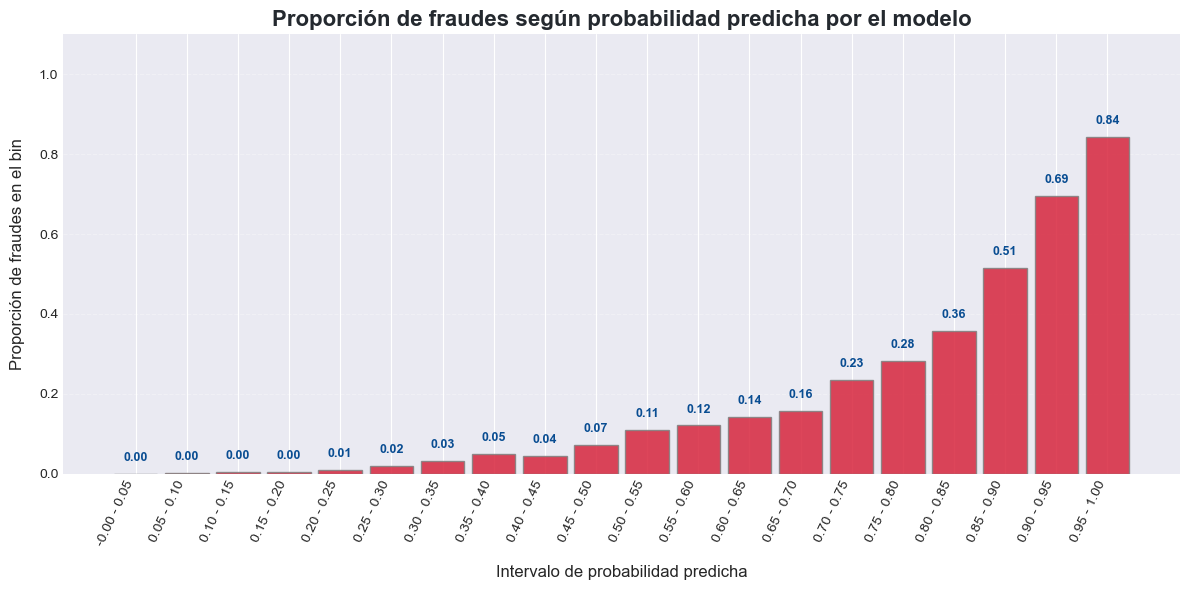

In [8]:
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
# Crear un DataFrame para agrupar probabilidades y etiquetas reales
df_pred = pd.DataFrame({
    "proba": y_proba_test,
    "fraude": y_test.reset_index(drop=True)
})

# Definir los bins para la probabilidad (ej: de 0 a 1 en pasos de 0.05)
bins = np.arange(0, 1.01, 0.05)
df_pred["bin"] = pd.cut(df_pred["proba"], bins=bins, include_lowest=True)

# Calcular la proporción de fraude y el total por bin
proporcion_fraude = df_pred.groupby("bin")["fraude"].mean()
total_en_bin = df_pred.groupby("bin")["fraude"].count()

# Crear gráfico
plt.figure(figsize=(12,6))
bars = plt.bar(np.arange(len(proporcion_fraude)), proporcion_fraude, color="#d7263d", alpha=0.85, width=0.85, edgecolor='gray')

# Etiquetas en el eje x: mostrar el rango de probabilidades
xticks_labels = [f"{interval.left:.2f} - {interval.right:.2f}" for interval in proporcion_fraude.index]
plt.xticks(np.arange(len(proporcion_fraude)), labels=xticks_labels, rotation=65, ha='right', fontsize=10)

# Añadir el valor de la proporción encima de la barra (0 a 1)
for i, prop in enumerate(proporcion_fraude):
    plt.text(i, prop + 0.025, f"{prop:.2f}", ha='center', va='bottom', fontsize=9, weight='bold', color="#094d92")

# Ejes y título más descriptivos
plt.title("Proporción de fraudes según probabilidad predicha por el modelo", fontsize=16, weight='bold', color="#24292f")
plt.xlabel("Intervalo de probabilidad predicha", fontsize=12, labelpad=12)
plt.ylabel("Proporción de fraudes en el bin", fontsize=12, labelpad=10)
plt.ylim(0, 1.10)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
